Dans le cadre du projet 8 de la formation Data Scientist d'OpenClassrooms, voilà le notebook que j'ai utilisé pour le déploiement du script en PySpark sur Amazon EMR. Les paths renseignés correspondent donc au bucket S3 que j'ai créée avec les données qui y sont stockées. L'écriture des features pour chaque image se fait ensuite également sur ce bucket.

In [1]:
#Cette cellule initie la session Spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1691523938229_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1691523938229_0003,pyspark,idle,Link,Link,None,✔


On commence par importer les librairies.

In [3]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import io
import sys

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.ml.feature import PCA, StandardScaler
from pyspark.ml.functions import array_to_vector, vector_to_array

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

On créée des variables qui contiennent les url des images dans mon bucket ainsi que le dossier de sortie pour l'écriture des résultats.

In [4]:
PATH = "s3://p8-data-test"
PATH_Data = PATH+'/Test_sample'
PATH_Result = PATH+'/Results'

print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://p8-data-test
PATH_Data:   s3://p8-data-test/Test_sample
PATH_Result: s3://p8-data-test/Results

Pour lire les images stockés dans le bucket, on indique le format "binaryFile", en précisant l'extension ".png". L'option "recursiveFileLookup" permet ensuite de parcourir tous les sous-dossiers dans le dossier indiqué dans load.

In [5]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Avec cette commande, on obtient donc un dataframe Spark, qui contient les features affichées ci-dessous. On crée une nouvelle feature nommée "label", qui prend comme valeur le sous-dossier indiquant donc la catégorie réelle du fruit sur l'image.

In [6]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+-------------------------------------------------------+--------------+
|path                                                   |label         |
+-------------------------------------------------------+--------------+
|s3://p8-data-test/Test_sample/Cauliflower/r_176_100.jpg|Cauliflower   |
|s3://p8-data-test/Test_sample/Cauliflower/r_177_100.jpg|Cauliflower   |
|s3://p8-data-test/Test_sample/Cauliflower/r_178_100.jpg|Cauliflower   |
|s3://p8-data-test/Test_sample/Pineapple/3_100.jpg      |Pineapple     |
|s3://p8-data-test/Test_sample/Apple Golden 1/72_100.jpg|Apple Golden 1|
+-------------------------------------------------------+--------------+
only showing top 5 rows

None

On va maintenant prendre le modèle MobileNetV2 qui a été selectionné pour ce projet en raison de sa rapidité d'éxécution.
On y charge une première fois les poids, qu'on récupère ensuite afin de les propager sur tous les workers par la suite afin qu'ils travaillent tous puissent y accéder.
On y retire également la dernière couche afin de supprimer l'étape de classificaiton pré-intégrée car elle ne nous intéresse pas ici.

In [7]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

brodcast_weights = sc.broadcast(new_model.get_weights())

new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

On peut mettre tout ça sous forme de fonction, en utilisant la variable contenant les poids qu'on a définie juste avant.

In [8]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2()
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

On crée maintenant quelques fonctions pour préprocess les images.

In [9]:
def preprocess(content):
    """
   Passe les images sous format array et retourne les images après  le preprocessing intégré du modèle
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Créer les features des images à l'aide du modèle et retourne un pd.Series.
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    Applique une méthode sur la fonction de création de features.
    Permet de retourner la colonne contenant toutes les features sous format Array dans un Spark DataFrame.

    :param content_series_iter: Itérateur sur les données, sous forme de Series comme définies dans la fonction précédente.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1691523938229_0003/container_1691523938229_0003_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:403: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

In [10]:
model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

On va ensuite créer les features sur notre dataframe Spark. On sélectionne uniquement les colonnes "path" et "label" car elles nous intéressent, et on applique les fonctions définies ci-dessus sur "content" contenant les informations en binaire des images.

In [11]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Avant d'exporter ce dataframe, on va précéder à une réduction dimensionnelle. En effet, la colonne "features" comprend des array de plus de 1200 features, il n'est donc pas nécessaire de tout conserver. On applique donc un PCA avec un nombre de features à conserver afin de garder un maximum d'informations sur les images.

Pour cela, on doit tout d'abord transformer notre colonne "features" en Spark Vector pour être acceptée pour la PCA.
On applique également un StandardScaler avant la réduction afin d'égaliser nos données.

In [12]:
features_df = features_df.withColumn("features", array_to_vector("features"))

scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(features_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
features_df = features_df.withColumn("features", array_to_vector("features"))

scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(features_df)

df_scaled = scaler.transform(features_df)

pca = PCA(
    k = 10, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)

df_pca = pca.transform(df_scaled)
df_pca = df_pca.select('path','label','pcaFeatures')
df_pca = df_pca.withColumn("pcaFeatures", vector_to_array("pcafeatures"))

In [13]:
df_scaled = scaler.transform(features_df)

pca = PCA(
    k = 10, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)

df_pca = pca.transform(df_scaled)
df_pca = df_pca.select('path','label','pcaFeatures')
df_pca = df_pca.withColumn("pcaFeatures", vector_to_array("pcafeatures"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

On exporte ensuite le dataframe en format parquet dans le dossier destiné à nos résultats.

In [14]:
df_pca.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

On peut par la suite réimporter ce dataframe

In [15]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                        pcaFeatures
0  s3://p8-data-test/Test_sample/Ginger Root/41_1...  ...  [40.29174701534475, -22.683866861935243, -13.8...
1    s3://p8-data-test/Test_sample/Orange/55_100.jpg  ...  [-9.857876317446955, 1.8292885399600844, -3.74...
2  s3://p8-data-test/Test_sample/Apple Golden 1/7...  ...  [-0.2542846923136637, 2.604343709470542, 7.635...
3  s3://p8-data-test/Test_sample/Mandarine/207_10...  ...  [-6.4298846975556865, 0.8255793223336293, -2.7...
4  s3://p8-data-test/Test_sample/Cauliflower/r_17...  ...  [12.364073667309079, 19.200208185640165, 2.987...

[5 rows x 3 columns]

In [17]:
df.loc[0,'pcaFeatures'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(10,)

In [18]:
df['pcaFeatures'].apply(pd.Series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            0          1          2  ...          7          8          9
0   40.291747 -22.683867 -13.867313  ...  -0.395371  -1.361045   0.963898
1   -9.857876   1.829289  -3.748471  ...  -1.809420   0.870675   0.434046
2   -0.254285   2.604344   7.635429  ... -19.808544   0.210561  -2.154705
3   -6.429885   0.825579  -2.712281  ...  -3.148614  -1.420508  -2.444456
4   12.364074  19.200208   2.987442  ...   5.306657   0.203480  -3.119868
5   -3.476404   1.730891  10.840827  ...  12.687181   2.712671   1.633921
6   -7.571386   0.046302  -6.801445  ...  -0.538613   2.170946  -2.345532
7   19.808430 -14.646089  -3.760038  ...   8.414933   0.181859   1.779971
8    9.749016  19.368261   3.070350  ...  -4.267810  -5.096761  17.998783
9  -16.508486  -4.049143 -16.747965  ...  -0.533168  16.336675   4.028701
10  11.596390  20.410433   3.471135  ...   4.919322  -0.324373  -2.089353
11 -11.357408  -0.110641  -7.697198  ...   3.365826 -14.039599  -6.994949
12  13.292839  19.983537   3.407539  .

In [19]:
df['pcaFeatures'].apply(pd.Series).to_csv(PATH + '/pcaFeatures_matrix.csv', index=False, header=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Affichage PCA

In [20]:
df = pd.concat([df,df['pcaFeatures'].apply(pd.Series)], axis=1).drop(['pcaFeatures'], axis=1)
df.head(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...         9
0  s3://p8-data-test/Test_sample/Ginger Root/41_1...  ...  0.963898
1    s3://p8-data-test/Test_sample/Orange/55_100.jpg  ...  0.434046
2  s3://p8-data-test/Test_sample/Apple Golden 1/7...  ... -2.154705
3  s3://p8-data-test/Test_sample/Mandarine/207_10...  ... -2.444456
4  s3://p8-data-test/Test_sample/Cauliflower/r_17...  ... -3.119868

[5 rows x 12 columns]

In [21]:
explained_var = pca.explainedVariance.toArray()
cumulated_var = explained_var.cumsum()
labels = [str(x) for x in explained_var.round(1)]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
x_list = range(0,10)
list(x_list)
fig = plt.figure(figsize=(15,6))
plt.bar_label(container = plt.bar(x_list, explained_var),labels=labels)
plt.plot(x_list, cumulated_var,c="red",marker='o',label=labels)
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres", size=16)
plt.show(block=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

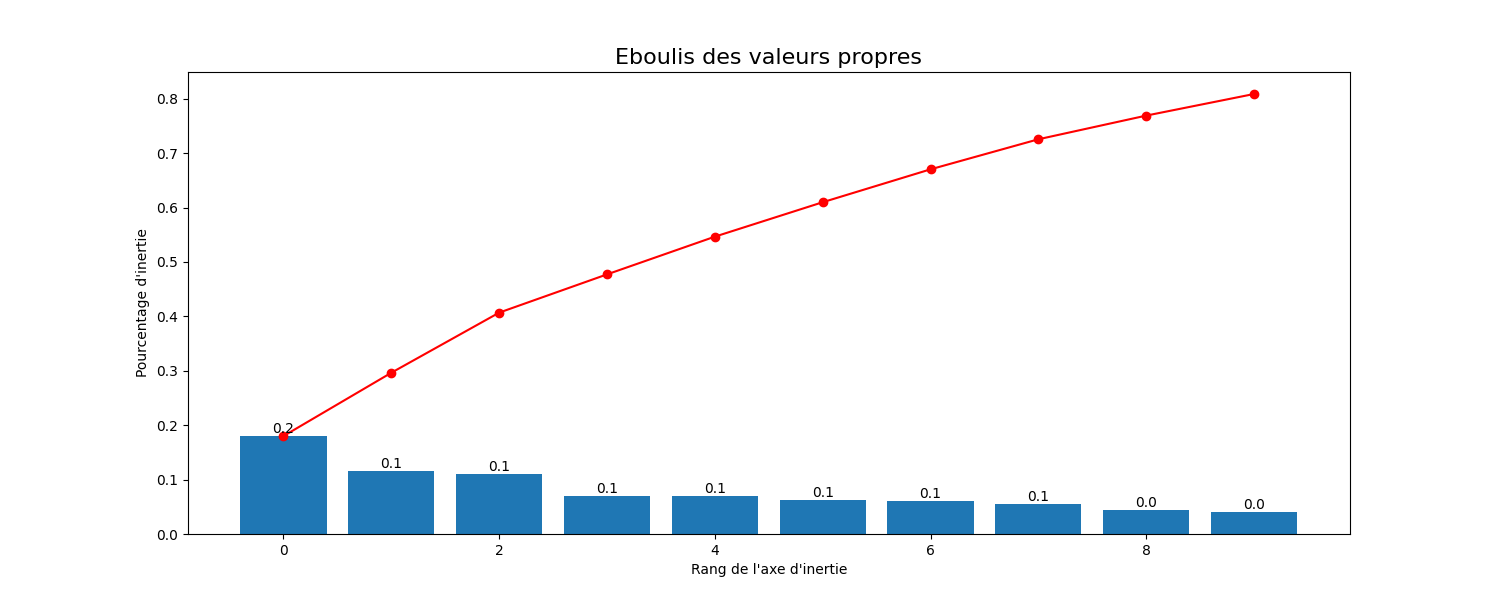

In [29]:
%matplot plt

In [25]:
l_cat = list(set(df.label))
num_cat = [(1-l_cat.index(df.label.iloc[i])) for i in range(len(df))]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()
scatter = ax.scatter(df[0], df[1], c=num_cat, cmap='Set1')
ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

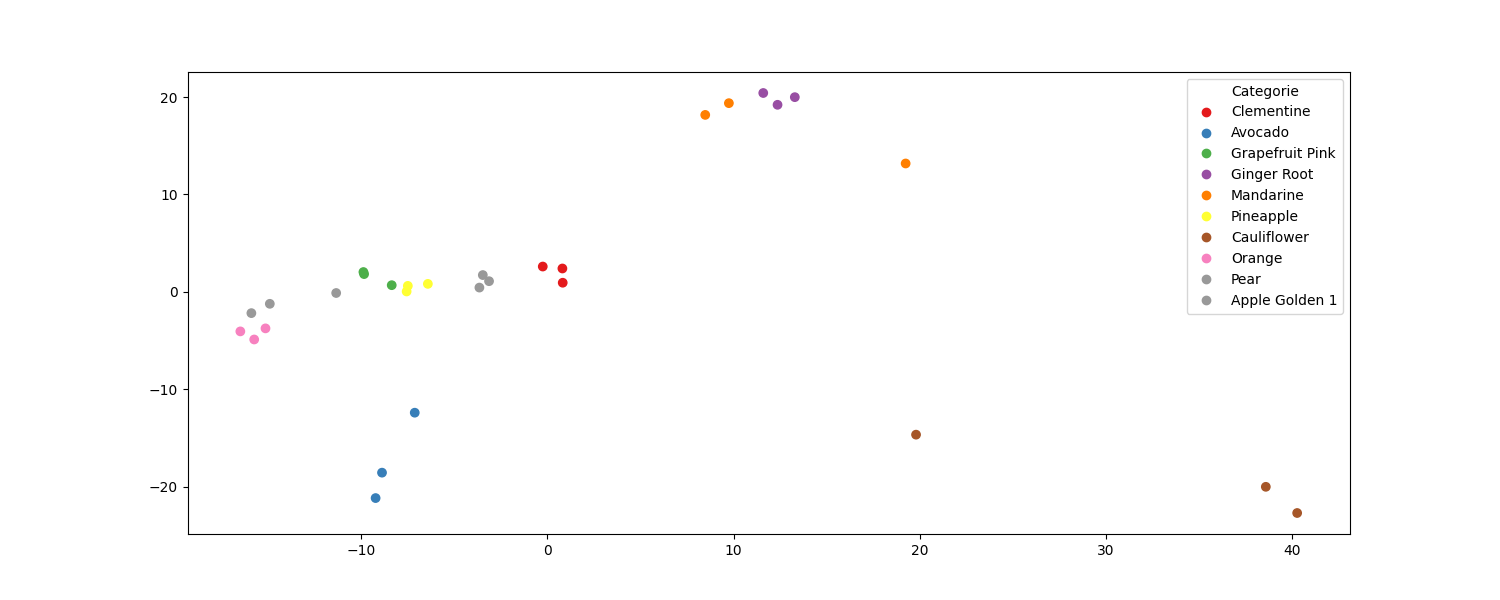

In [27]:
%matplot plt